In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import xhermes
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from sd1d.analysis import Case


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")

Done


In [2]:
db = CaseDB()

toload = {
    "base" : "sc10d-fix_ee_kappa_sqrt2",
    "nonrec" : "sc10e-no_neutral_reactions",
}

cs = dict()   # casestore

for name in toload:
    print(f"Loading {toload[name]}")
    cs[name] = Load.case_1D(db.casepaths[toload[name]], guard_replace = False, use_squash = False)

ds = cs["base"].ds

Loading sc10d-fix_ee_kappa_sqrt2
Skipping unnormalisation
Loading sc10e-no_neutral_reactions
Skipping unnormalisation


In [13]:
%matplotlib inline

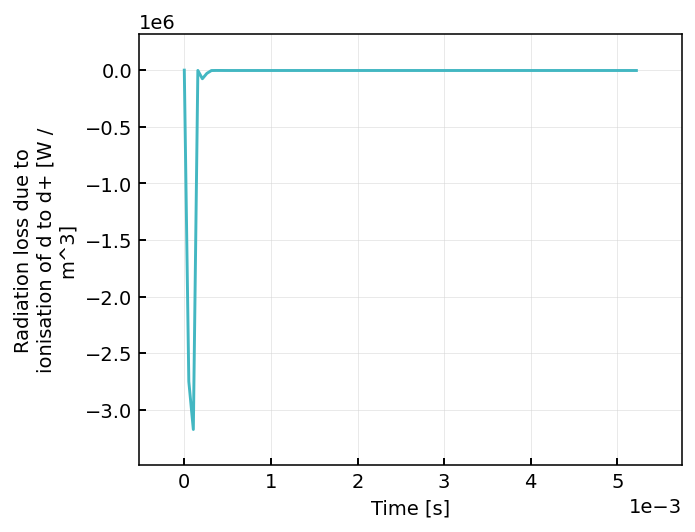

In [17]:
ds = cs["base"].ds.isel(pos=slice(2,-2))

# ds["Te"].plot(label = "Te")
# ds["Td+"].plot(label = "Ti")
# anim = xbout.plotting.animate.animate_line(ds["NVd+"])

fig, ax = plt.subplots()
(ds["Rd+_ex"] * ds["dv"]).sum("pos").plot(ax = ax)

# ds.data_vars

In [19]:
ds["Rd+_ex"].attrs["long_name"]

'Radiation loss due to ionisation of d to d+'

In [3]:
ds = cs['base'].ds.isel(pos = slice(2,-2), t = -1)

df = pd.DataFrame()
df.index = ds["pos"].values
df.index.name = "y"

for param in ["Ne", "Nd", "Pe", "Pd+", "Pe", "Te", "Td+", "Td"]:
    df[param] = ds[param].values


df["NVd+"] = ds["NVd+"] / (constants("mass_p")*2)
df["NVd"] = ds["NVd"] / (constants("mass_p")*2)

df.to_csv(rf"C:\Users\mikek\OneDrive\Project\collab\tech\cases\selcoll\{toload['base']}.csv")



(9.8, 10.05)

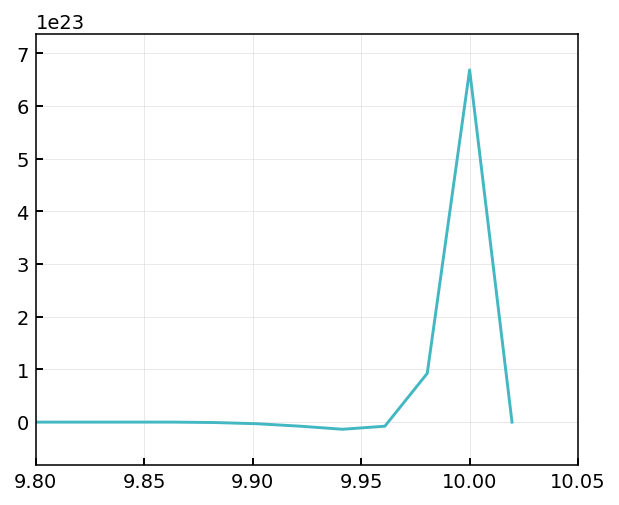

In [30]:
ds = cs['nonrec'].ds.isel(pos = slice(1,-1), t = -1)
flux = ds["NVd+"] / (constants("mass_p")*2)
flux[-1] = (flux[-1] + flux[-2])/2

fig, ax = plt.subplots()
ax.plot(ds["pos"], flux)
ax.set_xlim(9.8,10.05)

In [4]:
# ds = cs["noneut"].ds
ds = cs["base"].ds

if ds.metadata["guard_replaced"] is True:
    raise Exception("Balances must be done without guard replacement")

mp = constants("mass_p")
me = constants("mass_e")
qe = constants("q_e")
Zi = 1
AA = 2
sheath_ion_polytropic = 1

gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]

last = ds.isel(pos = -3)
guard = ds.isel(pos = -2)

def target(da):
    return (da.isel(pos = -2) + da.isel(pos = -3)) / 2

nesheath = target(ds["Ne"])
tesheath = target(ds["Te"])
tisheath = target(ds["Td+"])
vsheath = target(ds["Vd+"])

# Ion flow speed
C_i = np.sqrt((sheath_ion_polytropic * qe * tisheath + Zi * qe * tesheath) / (AA * mp))

# Parallel heat flux in W/m^2.
# Note: Corrected for 5/2Pe convective thermal flux, and small electron kinetic energy flux
# so gamma_e is the total *energy* flux coefficient.
q_e = ((gamma_e - 2.5) * qe * tesheath - 0.5 * me * vsheath**2) * nesheath * vsheath
q_i = gamma_i * qe * tisheath * nesheath * vsheath

dasheath = (last.dx * last.dz * (last.J + guard.J) / (np.sqrt(last.g_22 + guard.g_22)))

hfe = q_e * dasheath
hfi = q_i * dasheath
pf = vsheath * nesheath * dasheath

ds["hfe_sheath"] = hfe
ds["hfd+_sheath"] = hfi
ds["pfd+_sheath"] = pf

ds["hfe_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["hfd+_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["pfd+_sheath"].attrs.update(standard_name = "particle flux", units = "s^-1", source = "xHermes", long_name = "sheath particle flux")

## Checks

In [5]:
def limitFree(fm_arr, fc_arr):
    #  Limited free gradient of log of a quantity
    #  This ensures that the guard cell values remain positive
    #  while also ensuring that the quantity never increases
    # 
    #   fm  fc | fp
    #          ^ boundary
    # 
    #  exp( 2*log(fc) - log(fm) )
    # 
    
    if type(fm_arr) is float or type(fm_arr) is int:
        fm_arr = np.array([fm_arr])
        fc_arr = np.array([fc_arr])
        flatten = True
    else:
        flatten = False
        
    if type(last["Ne"]) is xarray.core.dataarray.DataArray:    
        fm_arr = fm_arr.values
        fc_arr = fc_arr.values
        
    out = np.zeros_like(fm_arr)
        
    for i, val in enumerate(fm_arr):
    
        fm = fm_arr[i]
        fc = fc_arr[i]
        
        
        if fm < fc:
            out[i] = fc    # Neumann
            
        if fm < 1e-10:
            out[i] = fc
        
        else:
            out[i] = fc**2 / fm
        
            
    if flatten:
        out = out[0]
        
    return out

In [8]:
ne_guard = limitFree(last["Ne"], guard["Ne"])
ti_guard = limitFree(last["Td+"], guard["Td+"])
te_guard = limitFree(last["Te"], guard["Te"])
pi_guard = limitFree(last["Pd+"], guard["Pd+"])
nvi_guard = 2 * constants("mass_p") *2 * 
# ti_guard = limitFree(last["Td+"], guard["Td+"])
# nesheath_check = 0.5 * (ne_guard + last["Ne"])


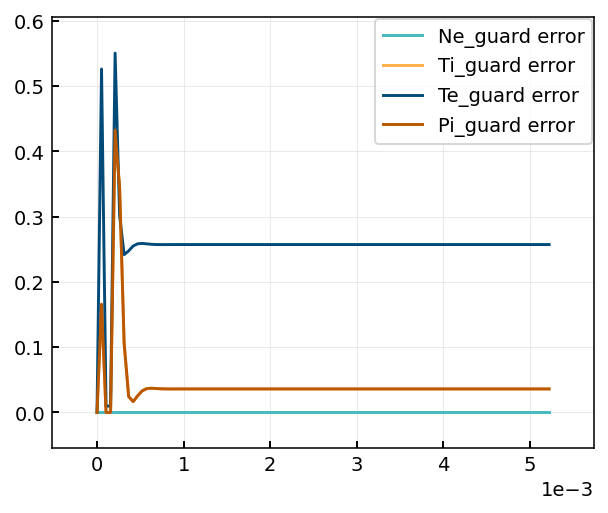

In [9]:
fig, ax = plt.subplots()
t = ds["t"]

ax.plot(t, 1- ne_guard / guard["Ne"], label= "Ne_guard error")
ax.plot(t, 1- ti_guard / guard["Td+"], label= "Ti_guard error")
ax.plot(t, 1- te_guard / guard["Te"], label= "Te_guard error")
ax.plot(t, 1- pi_guard / guard["Pd+"], label= "Pi_guard error")
# ax.plot(t, ne_guard,  label = "Check")

# ax.plot(t, guard["Td+"], label= "Code")
# ax.plot(t, ti_guard,  label = "Check")

ax.legend()

In [43]:
def tail(da):
    return da.isel(t=-1).values[-5:]

tail(ds["Nd+"]) * tail(ds["Vd+"]) * constants("mass_p")*2

array([-2.58958258e-05,  3.09511728e-04,  2.23527238e-03,  9.02188864e-03,
        0.00000000e+00])

In [44]:
tail(ds["NVd+"])

array([-2.58958257e-05,  3.09511728e-04,  2.23527237e-03, -2.23527237e-03,
        0.00000000e+00])

Text(0, 0.5, 'Particle flow [s^-1]')

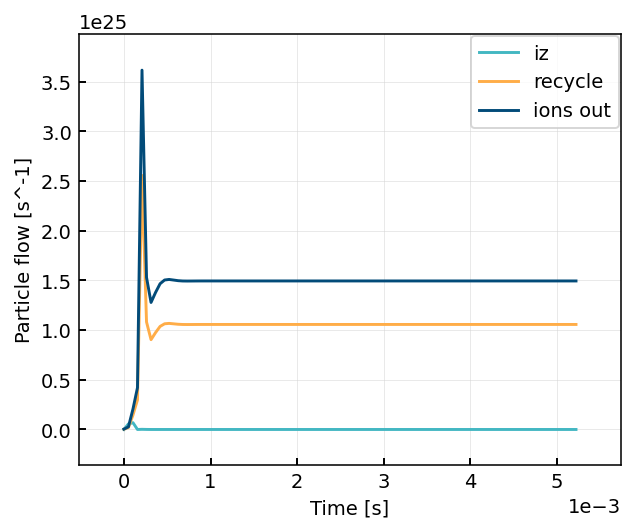

In [34]:
last = ds.isel(pos = -3)
dom = ds.isel(pos = slice(2,-2))

pf_iz = (dom["Sd+_iz"] * dom["dv"]).sum("pos")
pf_rec = (dom["Sd+_rec"] * dom["dv"]).sum("pos")
pf_recycle = (dom["Sd+_target_recycle"] * dom["dv"]).sum("pos")

pf_iz.plot(label = "iz")
pf_recycle.plot(label = "recycle")
ds["pfd+_sheath"].plot(label = "ions out")

plt.legend()
plt.ylabel("Particle flow [s^-1]")

In [19]:
ana = Case(str(db.casepaths["sc7cd-no_perpdiff_no_parcond"]))

In [15]:
ds = cs['base'].ds.isel(pos = slice(1,-1), t = -1)
pf_rec = ds["Sd+_target_recycle"].values[-2]
pf_i = (ds["NVd+"].values[-1] + ds["NVd+"].values[-2])/2

In [16]:
pf_i

0.0

>>> System mass balance
- Total in ---------------
- Input ion source = 0.000E+00 [s-1]
- Input neutral source = 0.000E+00 [s-1]
- Ionisation source = 1.834E+23 [s-1]
- Intended recycling source = 1.834E+23 [s-1]
- Total = 1.834E+23 [s-1]

- Total out ---------------
- Sheath ion flux = 0.000E+00 [s-1]
- Sheath neutral flux = 0.000E+00 [s-1]
- Recombination source = -2.740E+19 [s-1]
- Total = 2.740E+19 [s-1]

- Difference:
---> 1.834E+23 [s-1] (99.985%)


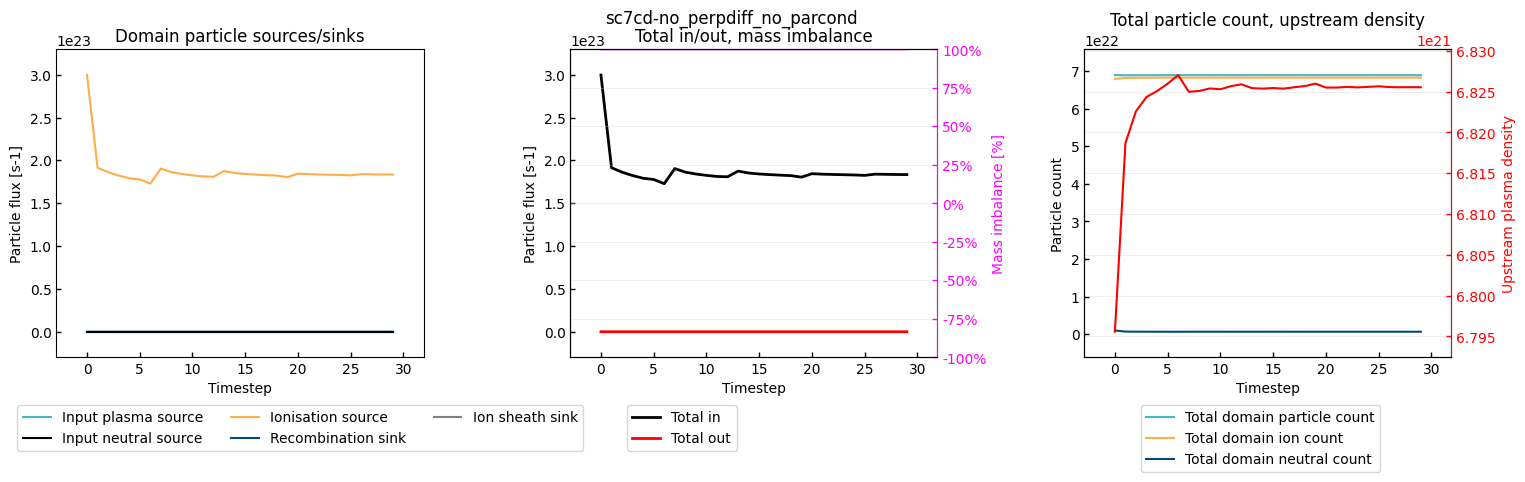

In [21]:
ana.mass_balance_hermes()

In [39]:
# ds = cs["noneut"].ds
ds = cs["base"].ds

if ds.metadata["guard_replaced"] is True:
    raise Exception("Balances must be done without guard replacement")

mp = constants("mass_p")
me = constants("mass_e")
qe = constants("q_e")
Zi = 1
AA = 2
sheath_ion_polytropic = 1

gamma_e = ds.options["sheath_boundary_simple"]["gamma_e"]
gamma_i = ds.options["sheath_boundary_simple"]["gamma_i"]

last = ds.isel(pos = -3)
guard = ds.isel(pos = -2)

def target(da):
    return (da.isel(pos = -2) + da.isel(pos = -3)) / 2

nesheath = target(ds["Ne"])
tesheath = target(ds["Te"])
tisheath = target(ds["Td+"])
vsheath = target(ds["Vd+"])

# Ion flow speed
C_i = np.sqrt((sheath_ion_polytropic * qe * tisheath + Zi * qe * tesheath) / (AA * mp))

# Parallel heat flux in W/m^2.
# Note: Corrected for 5/2Pe convective thermal flux, and small electron kinetic energy flux
# so gamma_e is the total *energy* flux coefficient.
q_e = ((gamma_e - 2.5) * qe * tesheath - 0.5 * me * vsheath**2) * nesheath * vsheath
q_i = gamma_i * qe * tisheath * nesheath * vsheath

dasheath = (last.dx * last.dz * (last.J + guard.J) / (np.sqrt(last.g_22 + guard.g_22)))

hfe = q_e * dasheath
hfi = q_i * dasheath
pf = vsheath * nesheath * dasheath

ds["hfe_sheath"] = hfe
ds["hfd+_sheath"] = hfi
ds["pfd+_sheath"] = pf

ds["hfe_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["hfd+_sheath"].attrs.update(standard_name = "heat flux", units = "W", source = "xHermes", long_name = "sheath heat flux")
ds["pfd+_sheath"].attrs.update(standard_name = "heat flux", units = "s^-1", source = "xHermes", long_name = "sheath particle flux")

In [37]:
da1 = (last.dx * last.dz * (last.J + guard.J) / (np.sqrt(last.g_22 + guard.g_22))).values
da2 = ((last.da + guard.da) / 2).values
print(da1)
print(da2)

8.885765876316732
6.283185307179586


Text(0, 0.5, 'Particle flow [s^-1]')

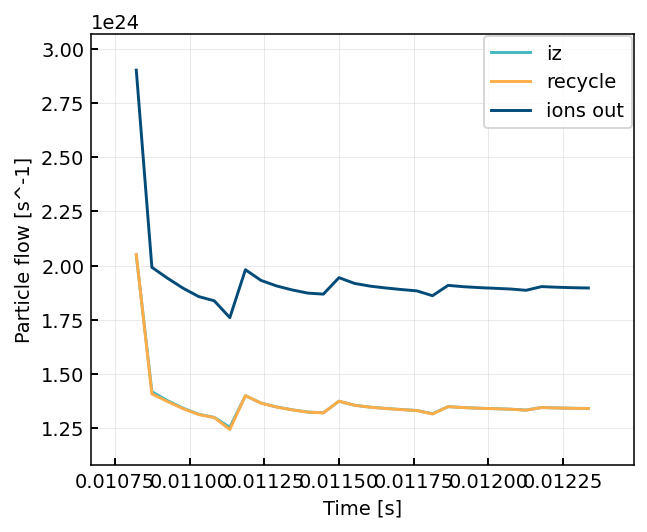

In [46]:
last = ds.isel(pos = -3)
dom = ds.isel(pos = slice(2,-2))

pf_iz = (dom["Sd+_iz"] * dom["dv"]).sum("pos")
pf_rec = (dom["Sd+_rec"] * dom["dv"]).sum("pos")
pf_recycle = (dom["Sd_target_recycle"] * dom["dv"]).sum("pos")

pf_iz.plot(label = "iz")
pf_recycle.plot(label = "recycle")
ds["pfd+_sheath"].plot(label = "ions out")

plt.legend()
plt.ylabel("Particle flow [s^-1]")

In [6]:
pflast = last["Ne"] * last["Vd+"] * last["da"]
ds["pfd+_sheath"].plot(label = "Sheath flux")
(last["Sd_target_recycle"] * last["dv"]).plot(label = "Recycle source")
pflast.plot(label = "last")
plt.legend()

Data variables:
    Bxy                 (pos) float64 dask.array<chunksize=(516,), meta=np.ndarray>
    Ed+_iz              (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Ed+_rec             (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Ed_target_recycle   (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Ed_target_refl      (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Edd+_cx             (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    EnergyFlow_d+_ylow  (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    EnergyFlow_e_ylow   (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Fd+_iz              (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Fd+_rec             (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
    Fdd+_cx             (t, pos) float64 dask.array<chunksize=(30, 516), meta=np.ndarray>
